# 📽️ Mini-Projet : Système de Recommandation de Films

**Approche collaborative & basée sur le contenu**

---

##  Contexte et objectif du projet

Les plateformes de streaming utilisent des **systèmes de recommandation** pour proposer aux utilisateurs des contenus adaptés à leurs goûts, afin de :

* améliorer l’expérience utilisateur,
* augmenter le temps passé sur la plateforme,
* favoriser la découverte de nouveaux contenus.

 **Objectif du projet**
Mettre en œuvre plusieurs approches de recommandation de films à partir du dataset **MovieLens 100k**, puis comparer leurs logiques et leurs résultats.

---

##  Données utilisées

Nous utilisons le dataset **MovieLens 100k**, qui contient :

* **100 000 notes**
* **943 utilisateurs**
* **1682 films**

In [2]:
#importation des données
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Dézipper si besoin
import os
DATA_DIR = "ml-100k"   # adapte si besoin

# Fichiers principaux
ratings_path = os.path.join(DATA_DIR, "u.data")
users_path   = os.path.join(DATA_DIR, "u.user")
items_path   = os.path.join(DATA_DIR, "u.item")
genres_path  = os.path.join(DATA_DIR, "u.genre")

# Ratings: user_id, item_id, rating, timestamp
ratings = pd.read_csv(
    ratings_path, sep="\t",
    names=["user_id","item_id","rating","timestamp"]
)

# Users: user_id|age|gender|occupation|zip_code
users = pd.read_csv(
    users_path, sep="|",
    names=["user_id","age","gender","occupation","zip_code"]
)

# Genres
genres = pd.read_csv(genres_path, sep="|", names=["genre","genre_id"]).dropna()
genre_names = genres["genre"].tolist()

# Items: movie_id|title|release_date|video_release_date|imdb_url|genre_flags...
item_cols = ["item_id","title","release_date","video_release_date","imdb_url"] + genre_names
items = pd.read_csv(items_path, sep="|", names=item_cols, encoding="latin-1")

print(ratings.head())
print(users.head())
print(items[["item_id","title"]].head())
print("Nb users:", ratings["user_id"].nunique(), "Nb items:", ratings["item_id"].nunique(), "Nb ratings:", len(ratings))

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213
   item_id              title
0        1   Toy Story (1995)
1        2   GoldenEye (1995)
2        3  Four Rooms (1995)
3        4  Get Shorty (1995)
4        5     Copycat (1995)
Nb users: 943 Nb items: 1682 Nb ratings: 100000


Exploration : utilisateurs, films, notes, genres


Sparsité matrice user-item: 0.9370 (93.70%)


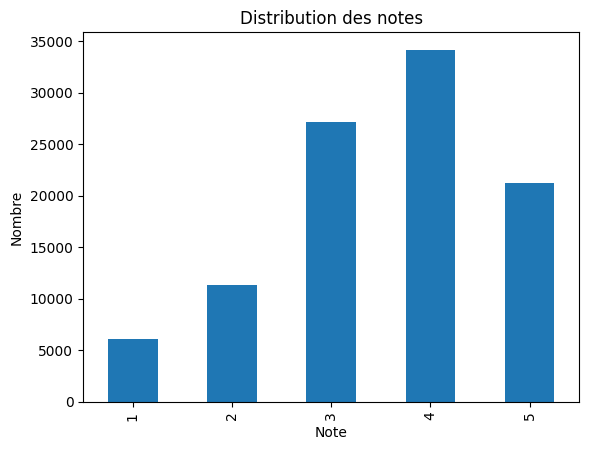

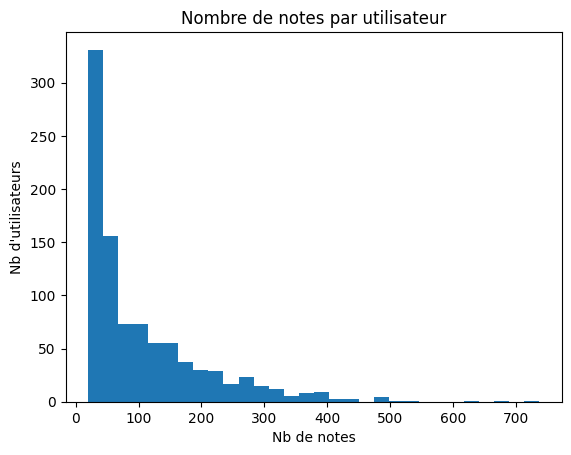

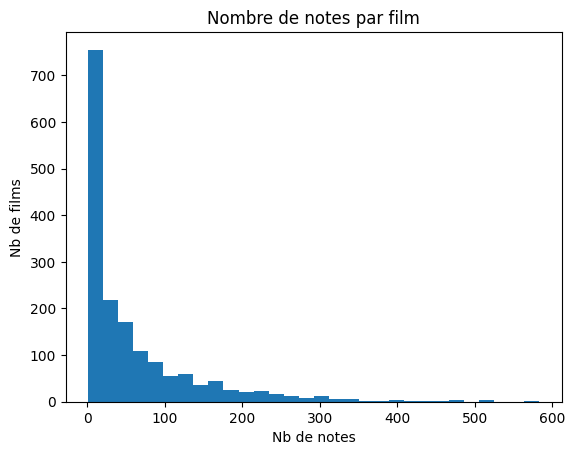

In [4]:
n_users = ratings["user_id"].nunique()
n_items = ratings["item_id"].nunique()
n_ratings = len(ratings)

sparsity = 1 - (n_ratings / (n_users * n_items))
print(f"Sparsité matrice user-item: {sparsity:.4f} ({sparsity*100:.2f}%)")

# Distributions
plt.figure()
ratings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution des notes")
plt.xlabel("Note")
plt.ylabel("Nombre")
plt.show()

ratings_per_user = ratings.groupby("user_id")["rating"].count()
plt.figure()
plt.hist(ratings_per_user, bins=30)
plt.title("Nombre de notes par utilisateur")
plt.xlabel("Nb de notes")
plt.ylabel("Nb d'utilisateurs")
plt.show()

ratings_per_item = ratings.groupby("item_id")["rating"].count()
plt.figure()
plt.hist(ratings_per_item, bins=30)
plt.title("Nombre de notes par film")
plt.xlabel("Nb de notes")
plt.ylabel("Nb de films")
plt.show()



##  Approche 1 : Filtrage collaboratif 

### 🔹 Principe général

Le filtrage collaboratif repose sur l’idée que :

> *des utilisateurs ayant eu des comportements similaires dans le passé auront des préférences similaires dans le futur.*

Deux variantes ont été implémentées :

* **User-based** : similarité entre utilisateurs
* **Item-based** : similarité entre films

Les similarités sont calculées avec :

* la **similarité cosinus**
* le **coefficient de Pearson**

Les notes sont ensuite **prédites par moyenne pondérée** des voisins les plus similaires.


In [5]:
# Matrice (users x items)
R = ratings.pivot_table(index="user_id", columns="item_id", values="rating")
print("Shape R:", R.shape)
print(R.head())


Shape R: (943, 1682)
item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5         NaN   NaN   NaN 

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

R_filled = R.fillna(0)

# Similarité user-user
user_cosine = pd.DataFrame(
    cosine_similarity(R_filled),
    index=R.index, columns=R.index
)

user_cosine.iloc[:3,:3]

user_id,1,2,3
user_id,,,
1,1.000000,0.166931,0.047460
2,0.166931,1.000000,0.110591
3,0.047460,0.110591,1.000000


In [7]:
# Similarité item-item
item_cosine = pd.DataFrame(
    cosine_similarity(R_filled.T),
    index=R.columns, columns=R.columns
)

item_cosine.iloc[:3,:3]

item_id,1,2,3
item_id,,,
1,1.000000,0.402382,0.330245
2,0.402382,1.000000,0.273069
3,0.330245,0.273069,1.000000


In [8]:
# Pearson user-user
user_pearson = R.T.corr(method="pearson")   # corr entre colonnes de R.T -> users

# Pearson item-item
item_pearson = R.corr(method="pearson")     # corr entre items

user_pearson.iloc[:3,:3], item_pearson.iloc[:3,:3]


(user_id         1         2        3
 user_id                             
 1        1.000000  0.160841  0.11278
 2        0.160841  1.000000  0.06742
 3        0.112780  0.067420  1.00000,
 item_id         1         2         3
 item_id                              
 1        1.000000  0.221784  0.175794
 2        0.221784  1.000000  0.230536
 3        0.175794  0.230536  1.000000)

In [9]:
def predict_user_based(u, item_id, sim_matrix, R, k=20, min_common=3):
    """
    Prédit la note de l'utilisateur u pour item_id (user-based CF).
    - sim_matrix: DataFrame user-user
    - min_common: nb minimal d'items co-notés (optionnel simple)
    """
    # utilisateurs qui ont noté item_id
    raters = R[item_id].dropna()
    if u not in R.index or item_id not in R.columns:
        return np.nan
    if item_id in R.columns and not np.isnan(R.loc[u, item_id]):
        return R.loc[u, item_id]

    # similarités u vs raters
    sims = sim_matrix.loc[u, raters.index].dropna()

    # garder top-k
    sims = sims.sort_values(ascending=False).head(k)

    if sims.empty:
        return np.nan

    # notes des voisins sur ce film
    neigh_ratings = raters.loc[sims.index]

    # moyenne pondérée
    denom = np.abs(sims).sum()
    if denom == 0:
        return np.nan
    return (sims * neigh_ratings).sum() / denom


def recommend_user_based(u, sim_matrix, R, k_neighbors=20, n_rec=10):
    seen = R.loc[u].dropna().index
    candidates = [i for i in R.columns if i not in seen]

    preds = []
    for i in candidates:
        p = predict_user_based(u, i, sim_matrix, R, k=k_neighbors)
        if not np.isnan(p):
            preds.append((i, p))
    preds.sort(key=lambda x: x[1], reverse=True)
    return preds[:n_rec]


In [10]:
def display_user_based_reco(user_id, sim_matrix, R, items, k_neighbors=30, n_rec=10):
    reco = recommend_user_based(user_id, sim_matrix, R, k_neighbors, n_rec)
    df = pd.DataFrame(reco, columns=["item_id", "predicted_rating"])
    df = df.merge(items[["item_id", "title"]], on="item_id", how="left")
    df["predicted_rating"] = df["predicted_rating"].round(2)
    return df[["item_id", "title", "predicted_rating"]]

display_user_based_reco(1, user_cosine, R, items)


,item_id,title,predicted_rating
0,814,"Great Day in Harlem, A (1994)",5.0
1,1122,They Made Me a Criminal (1939),5.0
2,1189,Prefontaine (1997),5.0
3,1201,Marlene Dietrich: Shadow and Light (1996),5.0
4,1467,"Saint of Fort Washington, The (1993)",5.0
5,1536,Aiqing wansui (1994),5.0
6,1599,Someone Else's America (1995),5.0
7,1653,Entertaining Angels: The Dorothy Day Story (1996),5.0
8,1293,Star Kid (1997),5.0
9,1500,Santa with Muscles (1996),5.0


In [11]:
def predict_item_based(u, item_id, sim_item, R, k=20):
    if u not in R.index or item_id not in R.columns:
        return np.nan
    if not np.isnan(R.loc[u, item_id]):
        return R.loc[u, item_id]

    user_ratings = R.loc[u].dropna()  # items notés par u
    if user_ratings.empty:
        return np.nan

    sims = sim_item.loc[item_id, user_ratings.index].dropna()
    sims = sims.sort_values(ascending=False).head(k)

    if sims.empty:
        return np.nan

    neigh_ratings = user_ratings.loc[sims.index]

    denom = np.abs(sims).sum()
    if denom == 0:
        return np.nan
    return (sims * neigh_ratings).sum() / denom


def recommend_item_based(u, sim_item, R, k_items=20, n_rec=10):
    seen = R.loc[u].dropna().index
    candidates = [i for i in R.columns if i not in seen]

    preds = []
    for i in candidates:
        p = predict_item_based(u, i, sim_item, R, k=k_items)
        if not np.isnan(p):
            preds.append((i, p))
    preds.sort(key=lambda x: x[1], reverse=True)
    return preds[:n_rec]


In [12]:
def display_item_based_reco(user_id, sim_item, R, items, k_items=30, n_rec=10):
    reco = recommend_item_based(user_id, sim_item, R, k_items, n_rec)
    df = pd.DataFrame(reco, columns=["item_id", "predicted_rating"])
    df = df.merge(items[["item_id", "title"]], on="item_id", how="left")
    df["predicted_rating"] = df["predicted_rating"].round(2)
    return df[["item_id", "title", "predicted_rating"]]

display_item_based_reco(1, item_cosine, R, items)


,item_id,title,predicted_rating
0,919,"City of Lost Children, The (1995)",4.61
1,813,"Celluloid Closet, The (1995)",4.59
2,1134,Get on the Bus (1996),4.58
3,285,Secrets & Lies (1996),4.56
4,922,Dead Man (1995),4.55
5,936,Brassed Off (1996),4.54
6,1010,Basquiat (1996),4.52
7,279,Once Upon a Time... When We Were Colored (1995),4.51
8,1008,I Shot Andy Warhol (1996),4.50
9,1171,Wild Reeds (1994),4.50


In [13]:
def show_recos(user_id, recos, items_df, title="Recommandations"):
    print(f"\n=== {title} pour user {user_id} ===")
    for item_id, score in recos[:10]:
        name = items_df.loc[items_df["item_id"] == item_id, "title"].values
        name = name[0] if len(name) else f"item {item_id}"
        print(f"{name:60s}  | score={score:.3f}")

# Choisir 5 utilisateurs (ex: aléatoires)
np.random.seed(42)
test_users = np.random.choice(R.index, size=5, replace=False)

# Choisir une similarité: cosinus ou pearson
# -> cosinus marche bien avec R.fillna(0) ; pearson peut produire plus de NaN.
user_sim = user_cosine
item_sim = item_cosine
# user_sim = user_pearson
# item_sim = item_pearson

for u in test_users:
    rec_u = recommend_user_based(u, user_sim, R, k_neighbors=30, n_rec=10)
    rec_i = recommend_item_based(u, item_sim, R, k_items=30, n_rec=10)

    show_recos(u, rec_u, items, "User-based")
    show_recos(u, rec_i, items, "Item-based")



=== User-based pour user 97 ===
Santa with Muscles (1996)                                     | score=5.000
Great Day in Harlem, A (1994)                                 | score=5.000
They Made Me a Criminal (1939)                                | score=5.000
Prefontaine (1997)                                            | score=5.000
Marlene Dietrich: Shadow and Light (1996)                     | score=5.000
Boys, Les (1997)                                              | score=5.000
Saint of Fort Washington, The (1993)                          | score=5.000
Aiqing wansui (1994)                                          | score=5.000
Someone Else's America (1995)                                 | score=5.000
Little City (1998)                                            | score=5.000

=== Item-based pour user 97 ===
Nothing Personal (1995)                                       | score=5.000
Brother's Kiss, A (1997)                                      | score=5.000
Ripe (1996)           

In [14]:
def overlap_topk(reco_a, reco_b, k=10):
    a = set([x[0] for x in reco_a[:k]])
    b = set([x[0] for x in reco_b[:k]])
    return len(a & b) / k

for u in test_users:
    rec_u = recommend_user_based(u, user_sim, R, k_neighbors=30, n_rec=10)
    rec_i = recommend_item_based(u, item_sim, R, k_items=30, n_rec=10)
    print(f"user {u} overlap top10 = {overlap_topk(rec_u, rec_i, 10):.2f}")


user 97 overlap top10 = 0.00
user 266 overlap top10 = 0.10
user 811 overlap top10 = 0.20
user 24 overlap top10 = 0.10
user 31 overlap top10 = 0.00


PARTIE 2

Approche 2 : Recommandation basée sur le contenu (Session 3)

Contrairement au filtrage collaboratif, la recommandation basée sur le contenu :

* **n’utilise pas les autres utilisateurs**
* se base uniquement sur les **caractéristiques des films** déjà appréciés par l’utilisateur


Préparer un “texte film” = titre + genres (+ description si dispo)

In [15]:
import re
import pandas as pd
import numpy as np

# items contient déjà les colonnes genres (0/1) + title
genre_cols = [c for c in items.columns if c not in ["item_id","title","release_date","video_release_date","imdb_url"]]

def build_movie_text(row):
    title = str(row["title"])
    # Nettoyage simple du titre (optionnel)
    title_clean = re.sub(r"\(\d{4}\)", "", title).strip()
    # genres à 1
    g = [col for col in genre_cols if row[col] == 1]
    genres_txt = " ".join(g)
    # Si tu as une vraie description : ajoute-la ici (row.get("description",""))
    return f"{title_clean} {genres_txt}".lower()

movie_profiles = items[["item_id","title"] + genre_cols].copy()
movie_profiles["text"] = movie_profiles.apply(build_movie_text, axis=1)

movie_profiles[["item_id","title","text"]].head()


,item_id,title,text
0,1,Toy Story (1995),toy story animation children's comedy
1,2,GoldenEye (1995),goldeneye action adventure thriller
2,3,Four Rooms (1995),four rooms thriller
3,4,Get Shorty (1995),get shorty action comedy drama
4,5,Copycat (1995),copycat crime drama thriller


TF-IDF sur les “descriptions” (ici texte construit)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words=None,      # tu peux mettre 'english' si tu veux filtrer, mais ici texte = titre+genres
    ngram_range=(1,2),
    min_df=2
)

X_tfidf = tfidf.fit_transform(movie_profiles["text"])
X_tfidf.shape


(1682, 963)

Profil utilisateur agrégé (TF-IDF)

On construit un vecteur utilisateur en faisant la moyenne pondérée des films qu’il a notés (poids = note centrée, ex: rating − 3).

In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def user_profile_tfidf(user_id, ratings_df, X_items, movie_id_to_idx, center=3.0):
    ur = ratings_df[ratings_df["user_id"] == user_id][["item_id","rating"]]
    ur = ur[ur["item_id"].isin(movie_id_to_idx)]
    if ur.empty:
        return None

    idxs = ur["item_id"].map(movie_id_to_idx).values
    w = (ur["rating"].values - center).astype(float)

    # on garde les films appréciés
    mask = w > 0
    if mask.sum() == 0:
        return None
    idxs = idxs[mask]
    w = w[mask]

    # moyenne pondérée sparse -> peut renvoyer np.matrix
    user_vec = X_items[idxs].multiply(w[:, None]).sum(axis=0) / w.sum()

    # ✅ conversion robuste
    user_vec = np.asarray(user_vec)
    if user_vec.ndim == 1:
        user_vec = user_vec.reshape(1, -1)
    return user_vec

def recommend_content_tfidf(user_id, ratings_df, movie_profiles, X_items, movie_id_to_idx, topn=10):
    prof = user_profile_tfidf(user_id, ratings_df, X_items, movie_id_to_idx)
    if prof is None:
        return pd.DataFrame(columns=["item_id","title","score"])

    scores = cosine_similarity(prof, X_items).ravel()

    seen = set(ratings_df[ratings_df["user_id"] == user_id]["item_id"].tolist())
    rec_idx = [i for i, mid in enumerate(movie_profiles["item_id"]) if mid not in seen]

    best = sorted(rec_idx, key=lambda i: scores[i], reverse=True)[:topn]
    out = movie_profiles.iloc[best][["item_id","title"]].copy()
    out["score"] = [scores[i] for i in best]
    out["score"] = out["score"].round(4)
    return out.reset_index(drop=True)


In [20]:
recommend_content_tfidf(
    user_id=1,
    ratings_df=ratings,
    movie_profiles=movie_profiles,
    X_items=X_tfidf,
    movie_id_to_idx=movie_id_to_idx,
    topn=10
)


,item_id,title,score
0,650,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",0.5760
1,1342,"Convent, The (Convento, O) (1995)",0.5760
2,1583,"Invitation, The (Zaproszenie) (1986)",0.5760
3,277,Restoration (1995),0.5176
4,292,Rosewood (1997),0.5176
5,330,187 (1997),0.5176
6,365,Powder (1995),0.5176
7,375,Showgirls (1995),0.5176
8,458,Nixon (1995),0.5176
9,468,Rudy (1993),0.5176


Recommander des films similaires à un film aimé (TF-IDF)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def similar_movies_tfidf(movie_id, movie_profiles, X_items, topn=10):
    if movie_id not in movie_id_to_idx:
        return pd.DataFrame()
    idx = movie_id_to_idx[movie_id]
    sims = cosine_similarity(X_items[idx], X_items).ravel()
    best = np.argsort(-sims)[1:topn+1]  # exclure lui-même
    out = movie_profiles.iloc[best][["item_id","title"]].copy()
    out["similarity"] = sims[best].round(4)
    return out.reset_index(drop=True)

# Exemple: films similaires au film 50 (Star Wars)
similar_movies_tfidf(50, movie_profiles, X_tfidf, topn=10)


,item_id,title,similarity
0,181,Return of the Jedi (1983),0.7382
1,271,Starship Troopers (1997),0.6608
2,172,"Empire Strikes Back, The (1980)",0.6537
3,121,Independence Day (ID4) (1996),0.5127
4,235,Mars Attacks! (1996),0.5026
5,62,Stargate (1994),0.4777
6,373,Judge Dredd (1995),0.4777
7,877,Excess Baggage (1997),0.4769
8,380,Star Trek: Generations (1994),0.4733
9,230,Star Trek IV: The Voyage Home (1986),0.4331


Word2Vec embeddings (contenu)

Ici on crée des embeddings de mots à partir de nos textes, puis on fait un embedding film = moyenne des embeddings de ses mots.

In [23]:
from gensim.models import Word2Vec

# Tokenisation simple
def tokenize(text):
    return re.findall(r"[a-zA-Z]+", text.lower())

sentences = movie_profiles["text"].apply(tokenize).tolist()

w2v = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1   # skip-gram
)

def movie_embedding_w2v(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

X_w2v = np.vstack([movie_embedding_w2v(tokenize(t), w2v) for t in movie_profiles["text"]])
X_w2v.shape


(1682, 100)

5) Profil utilisateur agrégé (Word2Vec) + reco

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def user_profile_w2v(user_id, ratings_df, X_items, center=3.0):
    ur = ratings_df[ratings_df["user_id"] == user_id][["item_id","rating"]]
    ur = ur[ur["item_id"].isin(movie_id_to_idx)]
    if ur.empty:
        return None

    idxs = ur["item_id"].map(movie_id_to_idx).values
    w = (ur["rating"].values - center).astype(float)

    mask = w > 0
    if mask.sum() == 0:
        return None
    idxs = idxs[mask]
    w = w[mask]

    prof = (X_items[idxs] * w[:, None]).sum(axis=0) / w.sum()
    return prof

def recommend_content_w2v(user_id, ratings_df, movie_profiles, X_items, topn=10):
    prof = user_profile_w2v(user_id, ratings_df, X_items)
    if prof is None:
        return pd.DataFrame(columns=["item_id","title","score"])

    scores = cosine_similarity(prof.reshape(1,-1), X_items).ravel()
    seen = set(ratings_df[ratings_df["user_id"] == user_id]["item_id"].tolist())

    rec_idx = [i for i, mid in enumerate(movie_profiles["item_id"]) if mid not in seen]
    best = sorted(rec_idx, key=lambda i: scores[i], reverse=True)[:topn]

    out = movie_profiles.iloc[best][["item_id","title"]].copy()
    out["score"] = [scores[i] for i in best]
    out["score"] = out["score"].round(4)
    return out.reset_index(drop=True)

recommend_content_w2v(1, ratings, movie_profiles, X_w2v, topn=10)


,item_id,title,score
0,1044,"Paper, The (1994)",0.9999
1,1186,"Inkwell, The (1994)",0.9999
2,1241,"Van, The (1996)",0.9999
3,1614,"Reluctant Debutante, The (1958)",0.9999
4,1631,"Slingshot, The (1993)",0.9999
5,337,"House of Yes, The (1997)",0.9999
6,1312,"Pompatus of Love, The (1996)",0.9999
7,1026,"Lay of the Land, The (1997)",0.9999
8,808,"Program, The (1993)",0.9999
9,1006,Until the End of the World (Bis ans Ende der W...,0.9999


Comparer TF-IDF vs Word2Vec (rapide)

In [26]:
u = 1

tfidf_reco = recommend_content_tfidf(
    user_id=u,
    ratings_df=ratings,
    movie_profiles=movie_profiles,
    X_items=X_tfidf,
    movie_id_to_idx=movie_id_to_idx,
    topn=10
)

tfidf_reco


,item_id,title,score
0,650,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",0.5760
1,1342,"Convent, The (Convento, O) (1995)",0.5760
2,1583,"Invitation, The (Zaproszenie) (1986)",0.5760
3,277,Restoration (1995),0.5176
4,292,Rosewood (1997),0.5176
5,330,187 (1997),0.5176
6,365,Powder (1995),0.5176
7,375,Showgirls (1995),0.5176
8,458,Nixon (1995),0.5176
9,468,Rudy (1993),0.5176


Conclusion

Ce projet montre que :

* les **systèmes de recommandation** peuvent être implémentés avec différentes approches
* le **filtrage collaboratif** exploite les comportements collectifs
* la **recommandation basée sur le contenu** permet une personnalisation fine
* les **embeddings** (Word2Vec) améliorent la qualité sémantique des recommandations
